In [ ]:
import torch 
import os
import numpy as np
import random
import torch.nn as nn
from PacthEmbedding import *
from torch.utils.data import Dataset, DataLoader
from encoder import FeatureEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from scipy.optimize import linear_sum_assignment
import torch.optim as optim


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

#### Load and combine data


In [ ]:
def load_and_combine_data(data_folder, label_folder, max_files=None):
    data_files = sorted(os.listdir(data_folder))[:max_files]
    label_files = sorted(os.listdir(label_folder))[:max_files]

    combined_data = []
    combined_label = []

    for data_file, label_file in zip(data_files, label_files):
        data_path = os.path.join(data_folder, data_file)
        loaded_data = np.load(data_path)
        combined_data.append(loaded_data)

        label_path = os.path.join(label_folder, label_file)
        loaded_label = np.load(label_path)
        combined_label.append(loaded_label)

    combined_data = np.concatenate(combined_data, axis=0)
    combined_label = np.concatenate(combined_label, axis=0)

    return combined_data, combined_label

data_folder = './dataset/data/'
label_folder = '.dataset/label/'

test_data, test_label = load_and_combine_data(data_folder, label_folder, 2)

In [4]:
print(test_data.shape)
print(test_label.shape)

(2000, 32, 6, 32, 32)
(2000,)


#### Label mapping

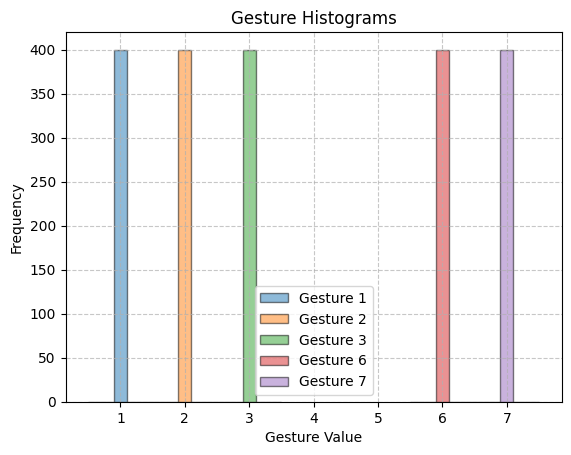

In [5]:
unique_gestures = np.unique(test_label)
plt.figure()

for gesture in unique_gestures:
    gesture_data = test_label[test_label == gesture]
    
    plt.hist(gesture_data, bins=len(unique_gestures), edgecolor='black', alpha=0.5, label=f'Gesture {gesture}')

plt.title('Gesture Histograms')
plt.xlabel('Gesture Value')
plt.ylabel('Frequency')
plt.legend() 
plt.grid(True, linestyle='--', alpha=0.7) 
plt.show()

In [6]:
def change_label(labels):
    labels = np.array(labels)
    labels[labels > 0] -= 1
    labels[labels > 2] -= 2
    
    return labels
test_label = change_label(test_label)

#### dataset and dataloader


In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self, patch_embed, encoder):
        super().__init__()
        self.patch_embed = patch_embed
        self.encoder = encoder

    def forward(self, x):
        tokens = self.patch_embed(x)
        cls_out = self.encoder(tokens)
        return cls_out
    

class MocoDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        item_label = self.label[idx]
        patch = torch.tensor(item, dtype=torch.float32)
        
        return patch, item_label
        

def Moco_data_loader(data, label, batch_size=64):
    dataset = MocoDataset(data, label)
    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    return test_loader

#### Load model file

In [8]:
patch_embed = ResnetPatchEmbed(num_channles= 6, feature_dim = 256, embed_dim = 256)

checkpoint = torch.load('checkpoints/Cluster-20250516-171717-ti.pth',map_location=torch.device('cpu'),weights_only=True)
encoder = FeatureEncoder(embed_dim=256, num_heads=8, encoder_depth=6, mask_ratio=0.0)
test_loader = Moco_data_loader(test_data, test_label)

feature_extractor = FeatureExtractor(patch_embed, encoder)
feature_extractor.patch_embed.load_state_dict(checkpoint['patch_embed'])
feature_extractor.encoder.load_state_dict(checkpoint['encoder'])

<All keys matched successfully>

### Generate features

In [9]:
def extract_features(feature_extractor, dataloader):
    feature_extractor.eval() 
    features = []
    labels = []

    with torch.no_grad():
        for x, y in dataloader:
            feature = feature_extractor(x) 
            features.append(feature.cpu())
            labels.append(y.cpu())

    features = torch.cat(features, dim=0)  
    labels = torch.cat(labels, dim=0) 
    return features.numpy(), labels.numpy()

features, labels = extract_features(feature_extractor, test_loader)

In [10]:
Cluster_list = ['Push', 'SwipeLeft', 'SwipeRight', 'SwipeUp', 'SwipeDown']
Cluster_list

['Push', 'SwipeLeft', 'SwipeRight', 'SwipeUp', 'SwipeDown']

In [11]:
def plot_clusters(ax, features_2d, y_pred_mapped, Cluster_list, title, xlabel, ylabel):
    for i in range(len(Cluster_list)):
        ax.scatter(
            features_2d[y_pred_mapped == i, 0],  
            features_2d[y_pred_mapped == i, 1],  
            label=f'{Cluster_list[i]}',     
            alpha=0.7,                      
            s=50                            
        )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    
def visualize_features(features, labels, Cluster_list, perplexity=30):
   
   
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    features_tsne = tsne.fit_transform(features)

    fig, ax = plt.subplots(figsize=(8, 8))
    plot_clusters(ax, features_tsne, labels, Cluster_list, 
                  "t-SNE Visualization", "Dimension 1", "Dimension 2")
    
    plt.tight_layout()
    plt.show()
    

def visualize_knn_features(features, labels, Cluster_list, n_neighbors=5, perplexity=30):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(features, labels)
    y_pred = knn.predict(features)

    conf_matrix = confusion_matrix(labels, y_pred)
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)
    label_map = {old: new for old, new in zip(col_ind, row_ind)}

    y_pred_mapped = []
    for label in y_pred:
        if label in label_map:
            y_pred_mapped.append(label_map[label])
        else:
            y_pred_mapped.append(-1) 
    y_pred_mapped = np.array(y_pred_mapped)

    fig, ax = plt.subplots(figsize=(8, 8))
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    features_tsne = tsne.fit_transform(features)
    plot_clusters(ax, features_tsne, y_pred_mapped, Cluster_list, 
                  "t-SNE Visualization", "Dimension 1", "Dimension 2")

    plt.tight_layout()
    plt.show()

    acc = accuracy_score(labels, y_pred_mapped)
    print(f"Accuracy: {acc}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classification_report(labels, y_pred_mapped, target_names=Cluster_list))
    return y_pred_mapped

### Embedding visualization


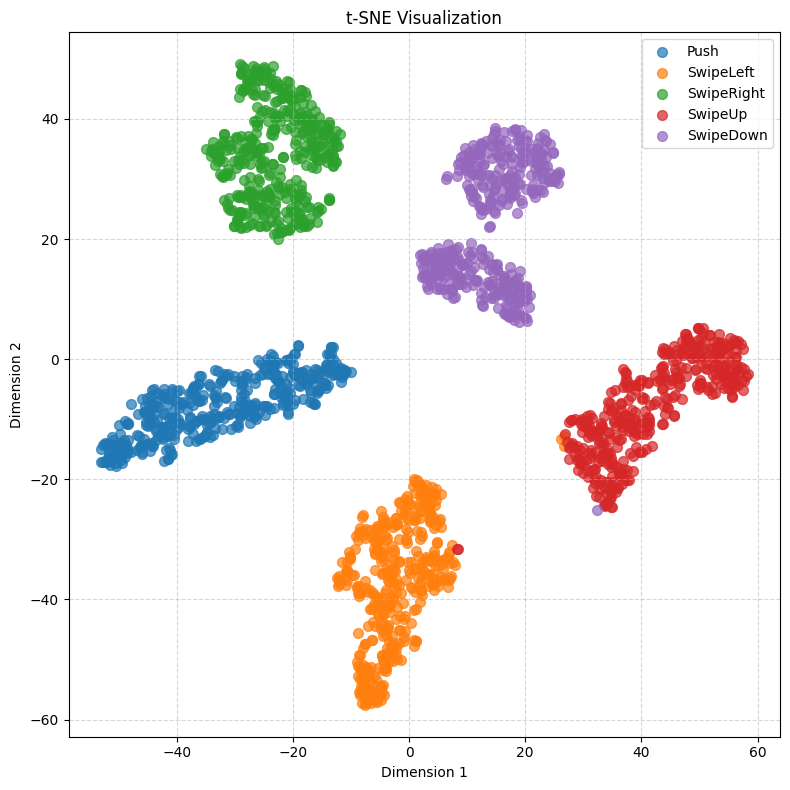

In [12]:
visualize_features(features, labels, Cluster_list)

#### Knn evaluation

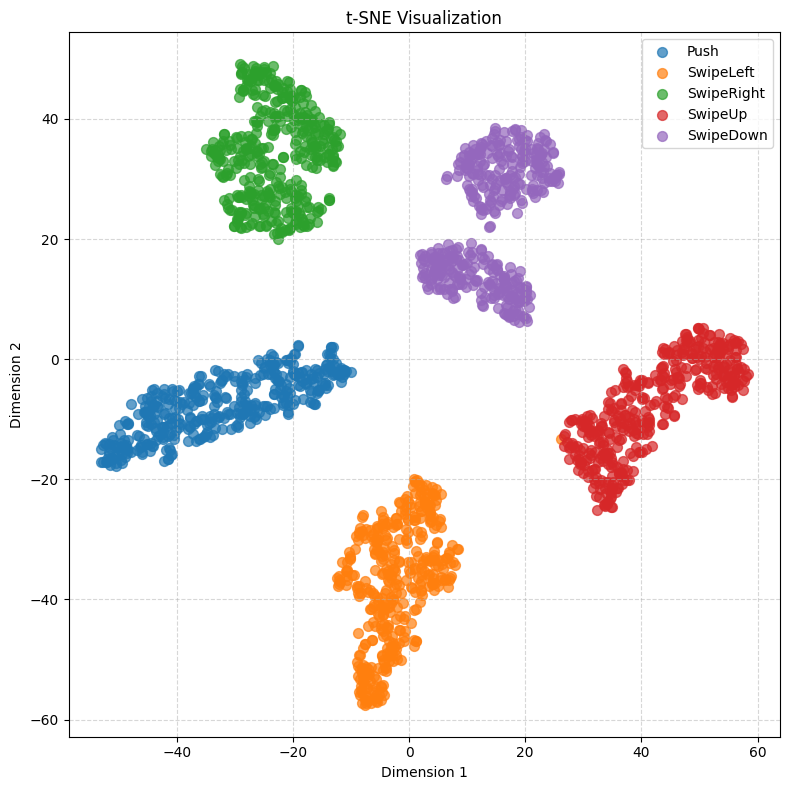

Accuracy: 0.9975
Confusion Matrix:
[[400   0   0   0   0]
 [  0 398   0   2   0]
 [  0   0 400   0   0]
 [  0   2   0 398   0]
 [  0   0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

        Push       1.00      1.00      1.00       400
   SwipeLeft       0.99      0.99      0.99       400
  SwipeRight       1.00      1.00      1.00       400
     SwipeUp       0.99      0.99      0.99       400
   SwipeDown       1.00      1.00      1.00       400

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [13]:
labels_knn = visualize_knn_features(features, labels, Cluster_list)

### Linear evaluation


In [ ]:
class GestureClassifier(nn.Module):
    def __init__(self, embed_dim=256, num_classes=6):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Dropout(p=0.2), 
            nn.Linear(embed_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        self._init_weights()

    def _init_weights(self):
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.classifier(x)

class FeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)  
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


def create_data_loaders(features, labels, batch_size=64):
    dataset = FeatureDataset(features, labels)
    train_size = len(dataset) // 2
    train_set = torch.utils.data.Subset(dataset, range(train_size))
    val_set = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size*2, shuffle=False)
    return train_loader, val_loader


def train_model(model, train_loader, val_loader, epochs=20, lr=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0
    best_model_path = 'best_model.pt'

    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0.0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()

        val_loss, val_acc, _ = evaluate(model, val_loader, criterion, device)
        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), best_model_path)

        print(f'Epoch {epoch+1}/{epochs}: '
              f'Train Loss: {train_loss/len(train_loader):.4f} '
              f'Acc: {correct/len(train_loader.dataset):.4f} | '
              f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    print(f'Best Validation Accuracy: {best_acc:.4f}')
    model.load_state_dict(torch.load(best_model_path, weights_only=False))

def evaluate(model, dataloader, criterion, device):
    model.eval()
    all_pred = []
    loss, correct = 0.0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim = 1)

            loss += criterion(outputs, y).item()
            correct += (preds == y).sum().item()
            all_pred.extend(preds.tolist())

    return loss/len(dataloader), correct/len(dataloader.dataset), all_pred


### Test model

In [18]:
model = GestureClassifier(embed_dim=256, num_classes=len(Cluster_list))
train_loader, val_loader = create_data_loaders(features, labels)
train_model(model, train_loader, val_loader, epochs=100, lr=1e-3)


Epoch 1/100: Train Loss: 7.8836 Acc: 0.2270 | Val Loss: 2.6087 Acc: 0.3850
Epoch 2/100: Train Loss: 3.4878 Acc: 0.3830 | Val Loss: 0.8116 Acc: 0.7880
Epoch 3/100: Train Loss: 2.2984 Acc: 0.5100 | Val Loss: 0.4613 Acc: 0.7490
Epoch 4/100: Train Loss: 1.3929 Acc: 0.6320 | Val Loss: 0.1188 Acc: 0.9930
Epoch 5/100: Train Loss: 0.8580 Acc: 0.7430 | Val Loss: 0.1175 Acc: 0.9710
Epoch 6/100: Train Loss: 0.7641 Acc: 0.7490 | Val Loss: 0.0884 Acc: 0.9830
Epoch 7/100: Train Loss: 0.6004 Acc: 0.8240 | Val Loss: 0.1361 Acc: 0.9460
Epoch 8/100: Train Loss: 0.4597 Acc: 0.8440 | Val Loss: 0.0680 Acc: 0.9850
Epoch 9/100: Train Loss: 0.3544 Acc: 0.8910 | Val Loss: 0.0436 Acc: 0.9950
Epoch 10/100: Train Loss: 0.3616 Acc: 0.8830 | Val Loss: 0.0794 Acc: 0.9670
Epoch 11/100: Train Loss: 0.2777 Acc: 0.9210 | Val Loss: 0.0497 Acc: 0.9890
Epoch 12/100: Train Loss: 0.2462 Acc: 0.9190 | Val Loss: 0.0633 Acc: 0.9840
Epoch 13/100: Train Loss: 0.1878 Acc: 0.9410 | Val Loss: 0.0988 Acc: 0.9590
Epoch 14/100: Train L